## Цель и описание проекта Telecom

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.  
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия для удержания клиента.
Что в свою очередь будет увеличивать Lifetime value.  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  

В нашем распоряжении будет 4 файла с данными:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиентов;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.  

Мы будем решать задачу бинарной классификации с основной метрикой ROC-AUC.

Верхнеуровневый план работы:
- Загрузка и предобработка данных
- Исследовательский анализ данных
- Машинное обучение
- Проверка лучшей модели на тестовой выборке
- Исследование важности признаков лучшей модели

## Установка дополнительных библиотек и импорты

In [3]:
! pip install catboost -U
! pip install lightgbm -U
! pip install phik -U
! pip install skimpy -U

In [4]:
import copy as cp

from pprint import pprint

import warnings

import catboost
from catboost import CatBoostClassifier

import lightgbm
from lightgbm import LGBMClassifier

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import phik
from phik import report
from phik.report import plot_correlation_matrix

import shap
shap.initjs()

import seaborn as sns
sns.set()

import skimpy
from skimpy import clean_columns

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import time

from tqdm import tqdm

In [5]:
warnings.filterwarnings("ignore")

## Загрузка и предобработка данных

В этой главе мы проведём загрузку и предобработку данных. План:


1. Загрузка данных и ознакомление с первыми строками, ознакомление с типами данных
2. Проверка наличия пропусков и дубликатов
3. Приведение названия колонок к змеиному регистру
4. Создание новых признаков
5. Выделение целевой переменной

In [6]:
dfs = {}
names = ['contract_new.csv', 'personal_new.csv', 'internet_new.csv', 'phone_new.csv']
for i, name in enumerate(names):
    pth1 = '/datasets/' + name
    pth2 = 'datasets/' + name
    pth3 = name
    names[i] = name.split(sep='_')[0]
    if os.path.exists(pth1):
        dfs[names[i]] = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        dfs[names[i]] = pd.read_csv(pth2)
    elif os.path.exists(pth3):
        dfs[names[i]] = pd.read_csv(pth3)
    else:
        print(f'Something is wrong with dataset {names[i]}')
    if len(dfs.get(names[i])) != 0:
        print(f'Dataset {names[i]} is loaded.')

Dataset contract is loaded.
Dataset personal is loaded.
Dataset internet is loaded.
Dataset phone is loaded.


In [7]:
for df in dfs:
    print(f'Dataset {df}')
    display(dfs[df].head(5))
    dfs[df].info()
    print('\nКоличество пропусков')
    display(pd.DataFrame(round(dfs[df].isna().mean()*100,)).style.background_gradient('coolwarm'))
    print(f'\nКоличество явных дубликатов {dfs[df].duplicated().sum()}')
    print('-' * 60)

Dataset contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Количество пропусков


,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000



Количество явных дубликатов 0
------------------------------------------------------------
Dataset personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Количество пропусков


,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000



Количество явных дубликатов 0
------------------------------------------------------------
Dataset internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Количество пропусков


,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000



Количество явных дубликатов 0
------------------------------------------------------------
Dataset phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Количество пропусков


,0
customerID,0.000000
MultipleLines,0.000000



Количество явных дубликатов 0
------------------------------------------------------------


Пропуски и явные дубликаты отсутствуют.  
Вероятнее всего к положительному классу будут относиться объекты, имеющее отличное от `No` значение признака `EndDate` датасета `contract`.  

In [8]:
# приведём название колонок к змеиному регистру

for df in dfs:
    dfs[df] = clean_columns(dfs[df], case='snake')
    print(dfs[df].columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


In [9]:
# проверим уникальность значений customerID для каждой таблицы
for name in names:
    print(dfs[name]['customer_id'].nunique() == len(dfs[name]['customer_id']))

True
True
True
True


Явные дубликаты отсутствуют

In [10]:
# визуально оценим зависимость customer_id от begin_date
dfs[names[0]].sort_values(by='customer_id').head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
2307,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73
3488,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.1
3845,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45
5931,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0
5569,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67


Зависимости `customer_id` от даты регистрации `begin_date` не наблюдается, установим в качестве индекса таблиц значение признака `customer_id`.

In [11]:
for name in names:
    dfs[name] = dfs[name].set_index('customer_id')

In [12]:
# объединим таблицы в одну
df = dfs[names[0]]
for i in range(1, len(names)):
    df = df.merge(dfs[names[i]], how='outer', on='customer_id')

In [13]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [14]:
# также посмотрим на количество строк / признаков в получившейся таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

In [15]:
# в признаке total_charges имеются строки ' '(новые клиенты), заменим на нулевые значения
df.loc[df['total_charges'] == ' ', 'total_charges'] = 0

In [16]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'

In [17]:
# поработаем с форматом данных
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['total_charges'] = df['total_charges'].astype(float)

In [18]:
# на освновании признака даты начала контрактных отношений создадим признак длительности жизни клиента с компанией в днях
df['customer_for_days'] = (df['end_date'] - df['begin_date']).dt.days.astype(int)

In [19]:
df[['begin_date', 'end_date', 'customer_for_days']].head()

,begin_date,end_date,customer_for_days
customer_id,,,
7590-VHVEG,2020-01-01,2020-02-01,31
5575-GNVDE,2017-04-01,2020-02-01,1036
3668-QPYBK,2019-10-01,2020-02-01,123
7795-CFOCW,2016-05-01,2020-02-01,1371
9237-HQITU,2019-09-01,2020-02-01,153


In [20]:
df[['begin_date', 'end_date', 'customer_for_days']].sort_values('end_date').head()

,begin_date,end_date,customer_for_days
customer_id,,,
7014-ZZXAW,2014-03-01,2014-06-01,92
7322-OCWHC,2014-02-01,2014-09-01,212
0266-CLZKZ,2014-07-01,2014-09-01,62
7694-VLBWQ,2014-04-01,2014-10-01,183
1555-DJEQW,2013-12-01,2014-11-01,335


In [21]:
df['senior_citizen'] = df['senior_citizen'].map({1:'Yes', 0:'No'})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

In [23]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_for_days
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,153


In [24]:
df['internet_service'] = df['internet_service'].fillna('no_service')
df['multiple_lines'] = df['multiple_lines'].fillna('no_service')
df = df.fillna('not_applicable')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

In [26]:
df.isna().mean()

begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
multiple_lines       0.0
customer_for_days    0.0
dtype: float64

In [27]:
# создадим целевой признак на основании `end_date`
df['churn'] = np.where(df['end_date'] == '2020-02-01', 0, 1)

In [28]:
df = df.drop(['begin_date', 'end_date'], axis=1)

### Вывод

В нашем распоряжении 4 файла с данными.  
При объединении таблиц в одну, появились пропуски, т.к. таблицы `internet` и `phone` имеют меньшее количество записей.  
Дубликаты отсутствуют, пропуски заполнены.  
Названия колонок приведены к змеиному регистру.  
Добавлен новый признак - срок жизни клиента в днях.  
Создана целевая переменная `churn` любого значения, кроме No столбца `end_date`.  

## EDA

На этом этапе посмотрим на распределение переменных, оценим коллинеарность.

In [29]:
df['churn'].value_counts(normalize=True)

churn
0    0.843675
1    0.156325
Name: proportion, dtype: float64

Наблюдается дисбаланс классов.

In [30]:
categorical = []
numerical = []
for i, tp in enumerate(df.dtypes):
    if tp == 'O':
        categorical.append(df.columns[i])
        
[numerical.append(col) for col in list(df.columns)[:-1] if col not in categorical];

In [31]:
categorical

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [32]:
numerical

['monthly_charges', 'total_charges', 'customer_for_days']

In [33]:
columns_to_show = ['monthly_charges', 'total_charges', 'customer_for_days']
for col in columns_to_show:
    print(col)
    display(df.groupby(['churn'])[col].describe(percentiles=[]))

monthly_charges


,count,mean,std,min,50%,max
churn,,,,,,
0,5942.0,62.763455,29.844462,18.25,69.2,118.60
1,1101.0,75.546004,29.116213,18.40,84.2,118.75


total_charges


,count,mean,std,min,50%,max
churn,,,,,,
0,5942.0,2067.866420,2193.898483,0.00,1192.80,9221.38
1,1101.0,2371.377275,1581.862275,77.84,2139.03,7649.76


customer_for_days


,count,mean,std,min,50%,max
churn,,,,,,
0,5942.0,893.681084,716.958551,0.0,702.0,2314.0
1,1101.0,924.863760,458.771309,28.0,915.0,2129.0


Среди оттёкших клиентов выше среднее значение `monthly_charges` выше (выше проникновение сервисов или более дорогие таррифы).

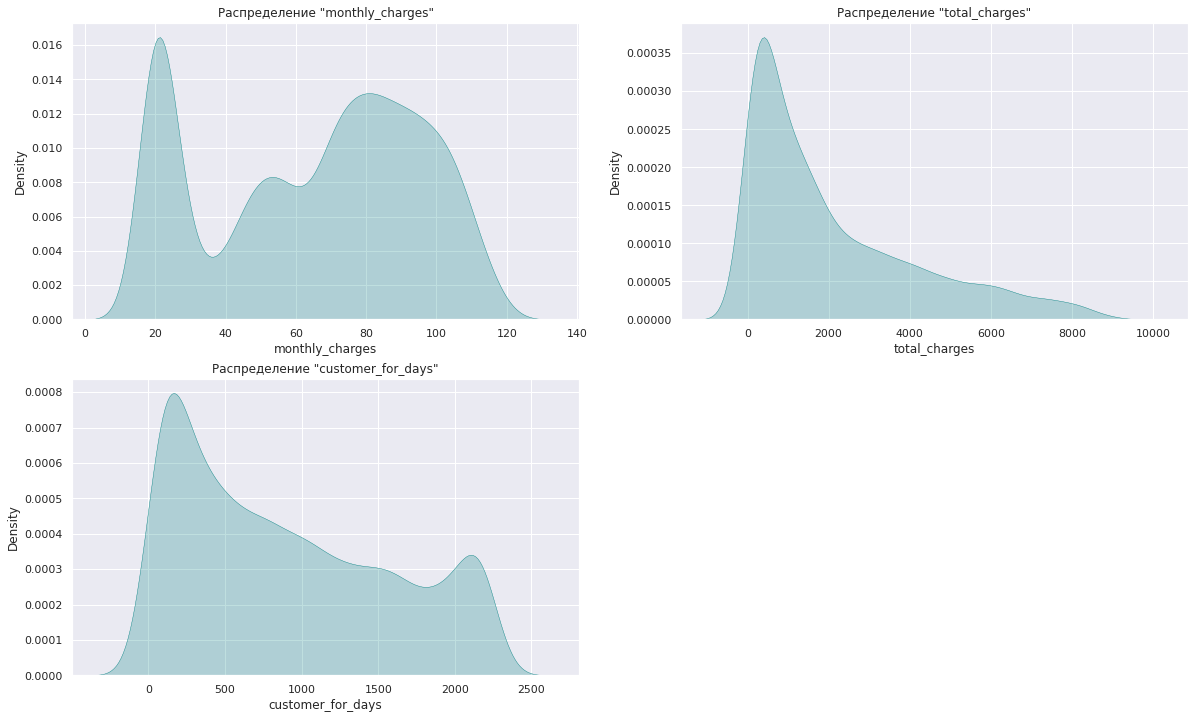

In [34]:
plt.figure(figsize=(20, 12))

for i, col in enumerate(numerical):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=df[col], color='teal', shade=True,linewidth=0.4)
    plt.title(f'Распределение "{col}"')
    
plt.show()

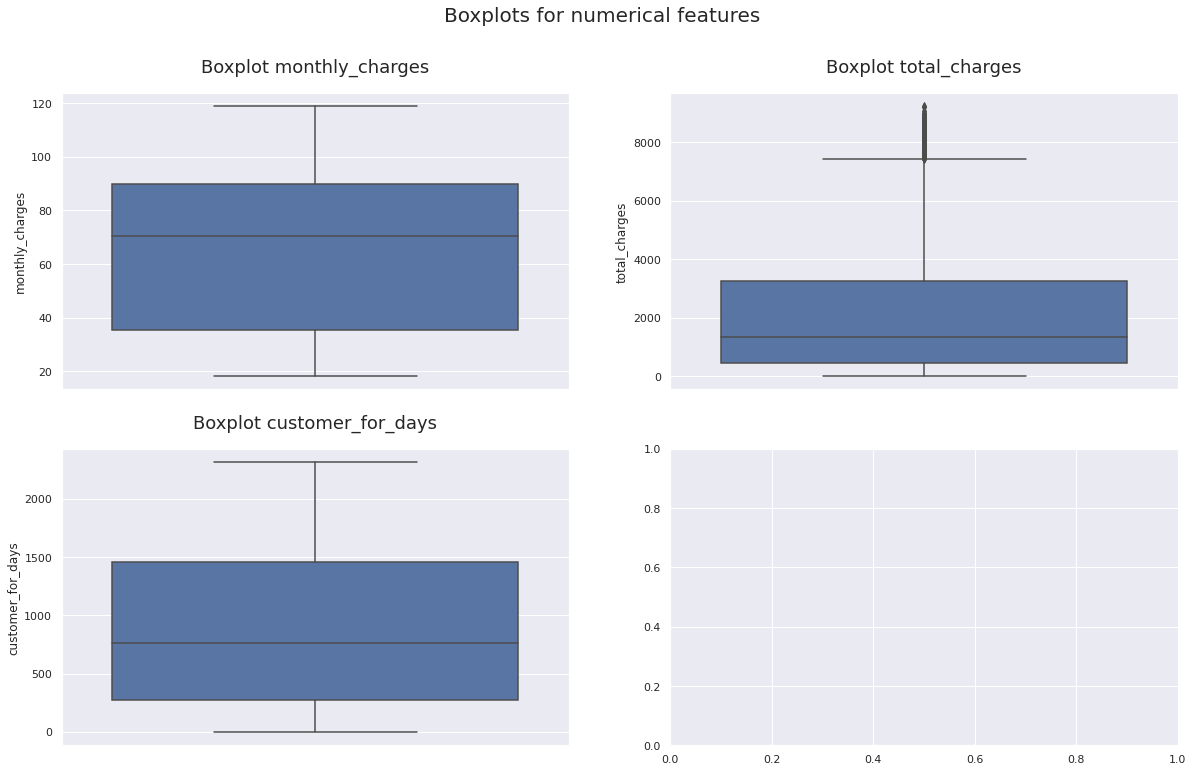

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Boxplots for numerical features', fontsize=20)
for i, n in enumerate(numerical):
    x,y = divmod(i,2)
    sns.boxplot(y=n, data=df, ax=axes[x,y]).set_title(f'Boxplot {n}', fontsize=18, y=1.05)

Аномалии отсутствуют, `total_charges` содержит ряд значений за пределами 1.5 IQR,  
вероятнее всего это "долгожители" среди пользователей услуг.  
Пиковые значения распределения `monthly_charges` расположены в районе 20 и 80 у.е.  

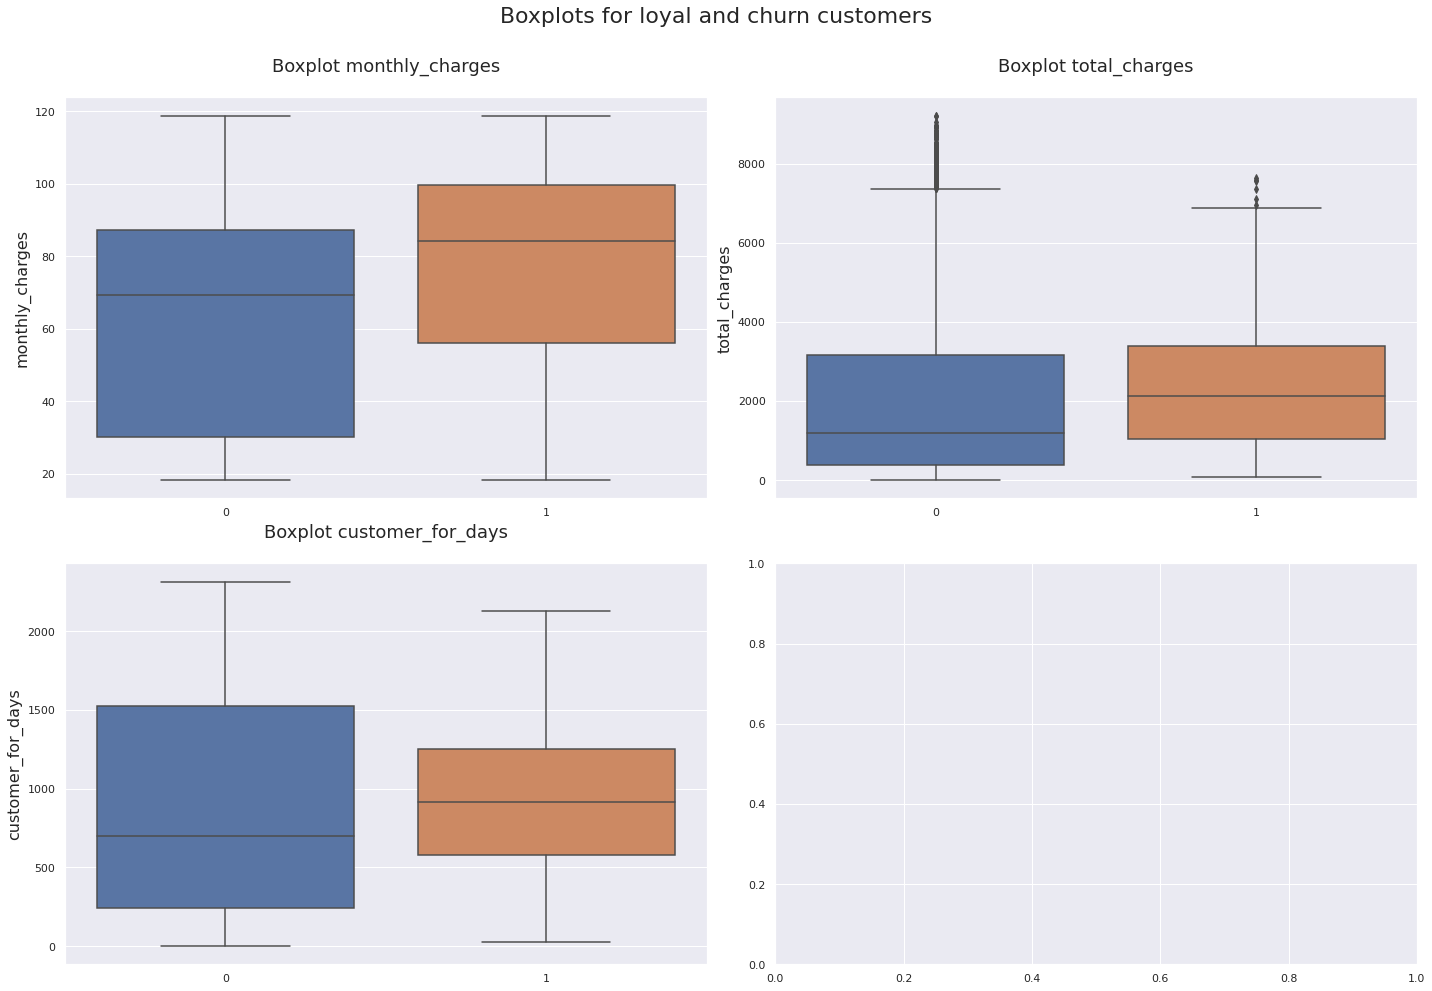

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Boxplots for loyal and churn customers', fontsize=22)
for i, col in enumerate(numerical):
    ax = axes[int(i / 2), i % 2]
    sns.boxplot(x='churn', y=col, data=df, ax=ax).set_title(f'Boxplot {col}', fontsize=18, y=1.05)
    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel(col, fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.89);

In [37]:
df[numerical].corr('pearson')

,monthly_charges,total_charges,customer_for_days
monthly_charges,1.000000,0.630440,0.220054
total_charges,0.630440,1.000000,0.821746
customer_for_days,0.220054,0.821746,1.000000


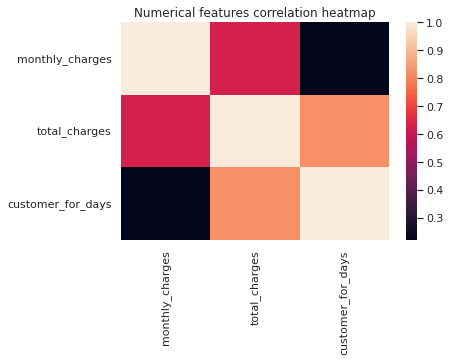

In [38]:
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix).set_title('Numerical features correlation heatmap');

Присутствует логичные корреляции между:
- заметная между `monthly_charges` и `total_charges`
- высокая между `total_charges` и `customer_for`
- очень высокая у признаков `customer_for` (ведь это по сути есть один и тот же признак в разных единицах измерения)

Слабая корреляция между `customer_for` и `monthly_charges`.

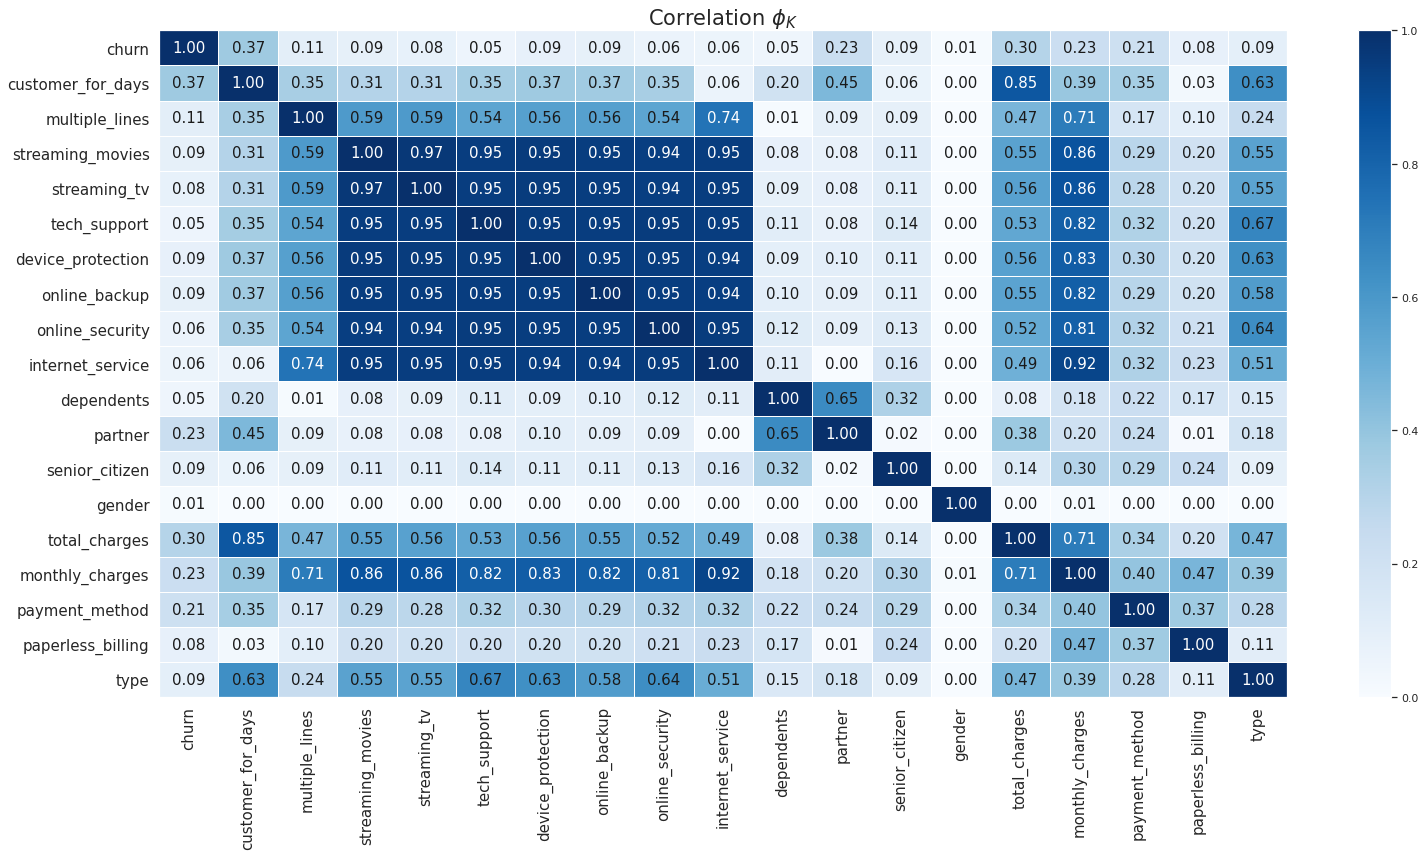

In [39]:
phik_overview = df.phik_matrix(interval_cols=numerical)

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                         vmin=0, vmax=1, color_map='Blues', title=r'Correlation $\phi_K$', fontsize_factor=1.5,
                         figsize=(22, 12))
plt.tight_layout()

In [40]:
significance_overview = df.significance_matrix(interval_cols=numerical)

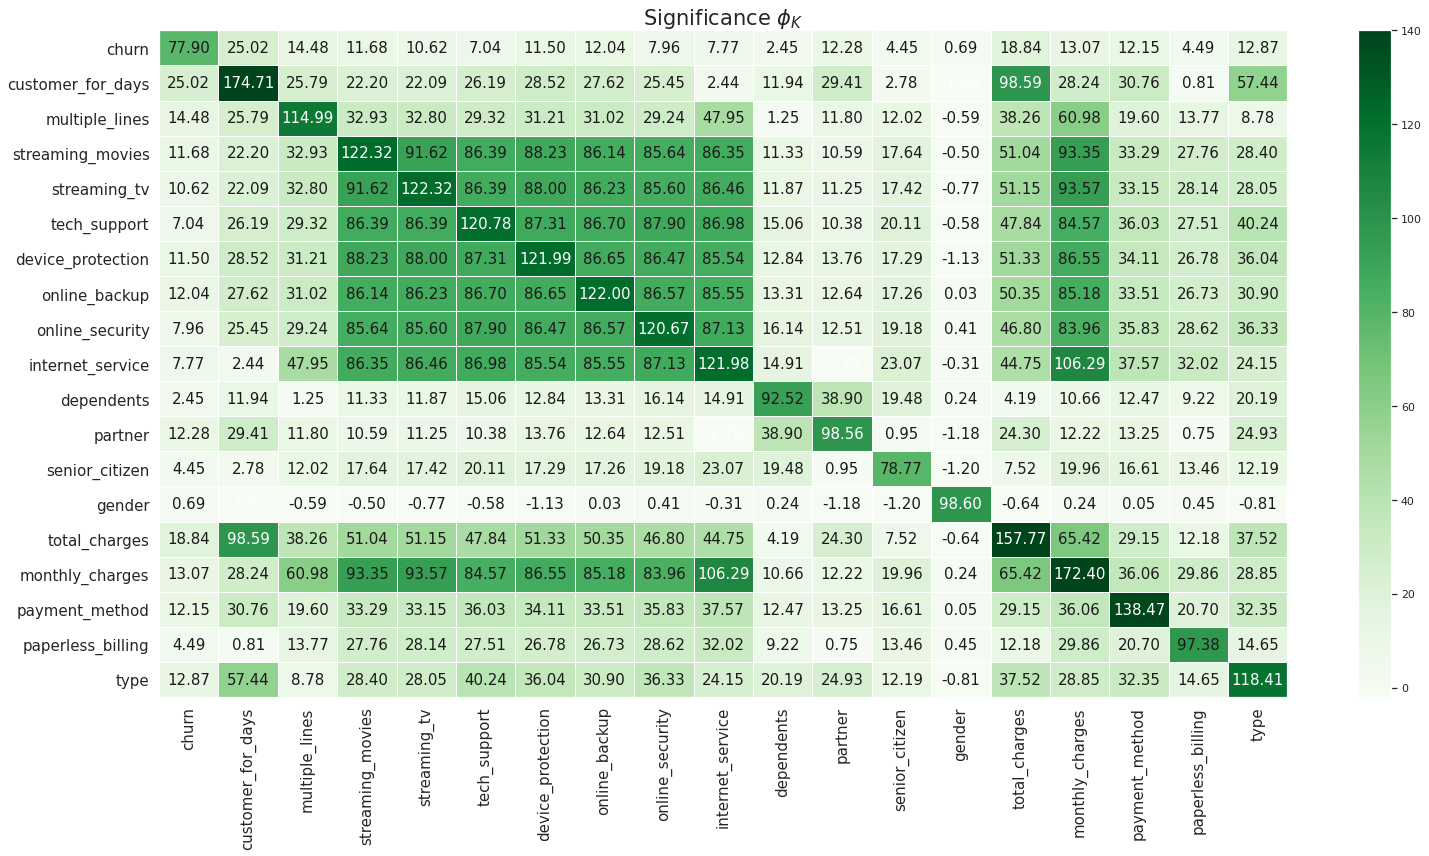

In [41]:
plot_correlation_matrix(significance_overview.values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, color_map='Greens',
                        title=r'Significance $\phi_K$', vmin=-2, vmax=140, fontsize_factor=1.5,
                        figsize=(22, 12))

Наибольшая корреляция наблюдается между суммарными расходами клиента и дополнительными услугами, что предсказуемо.
На этапе обучения стоит рассмотреть не использовать признаки со слабым уровнем корреляции с целевой переменной (`dependents`,`senior_citizen`, `gender`) и возможно другие. 

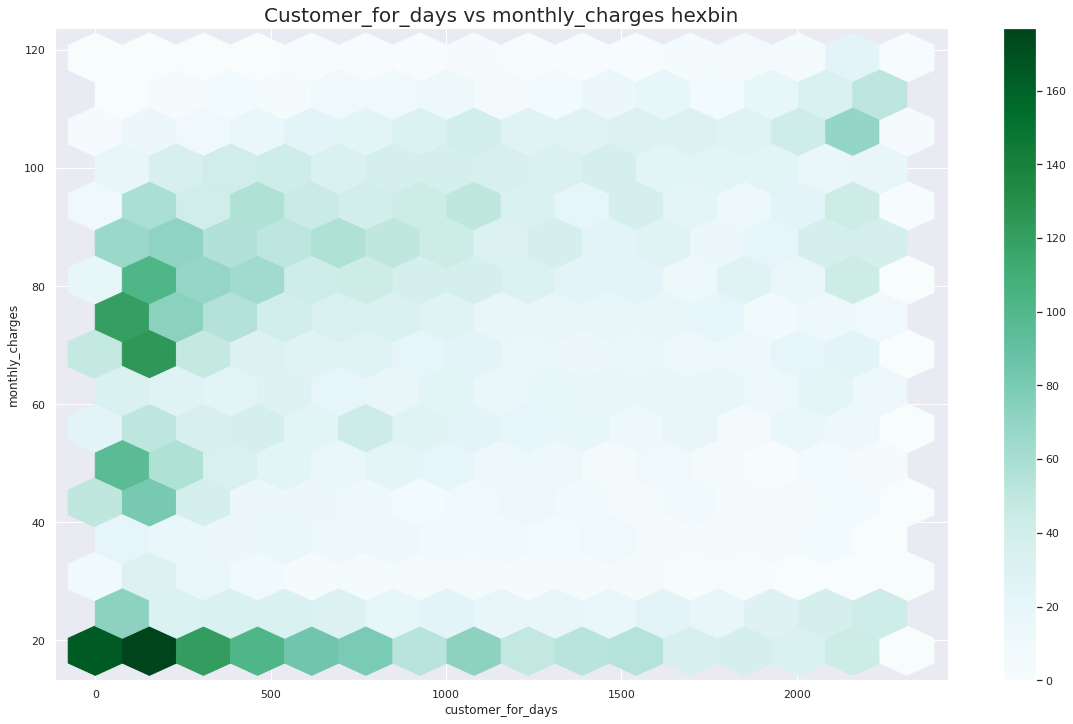

In [42]:
# Посмотрим на распределение переменных срока жизни и monhly_charges
# Возможно бОльшая часть клиентов заходит на базовые услуги/тарифы и хорошо кросселится в будущем
df.plot(x='customer_for_days',
        y='monthly_charges',
        kind='hexbin',
        gridsize=15,
        figsize=(20, 12), 
        sharex=False, 
        grid=True);
plt.title('Customer_for_days vs monthly_charges hexbin', fontsize=20);

Похоже, что присутствует внушительное количество клиентов "долгожителей" c низким показателем `monthly_charges`, стоит обратить внимание маркетологов/отдела продаж.

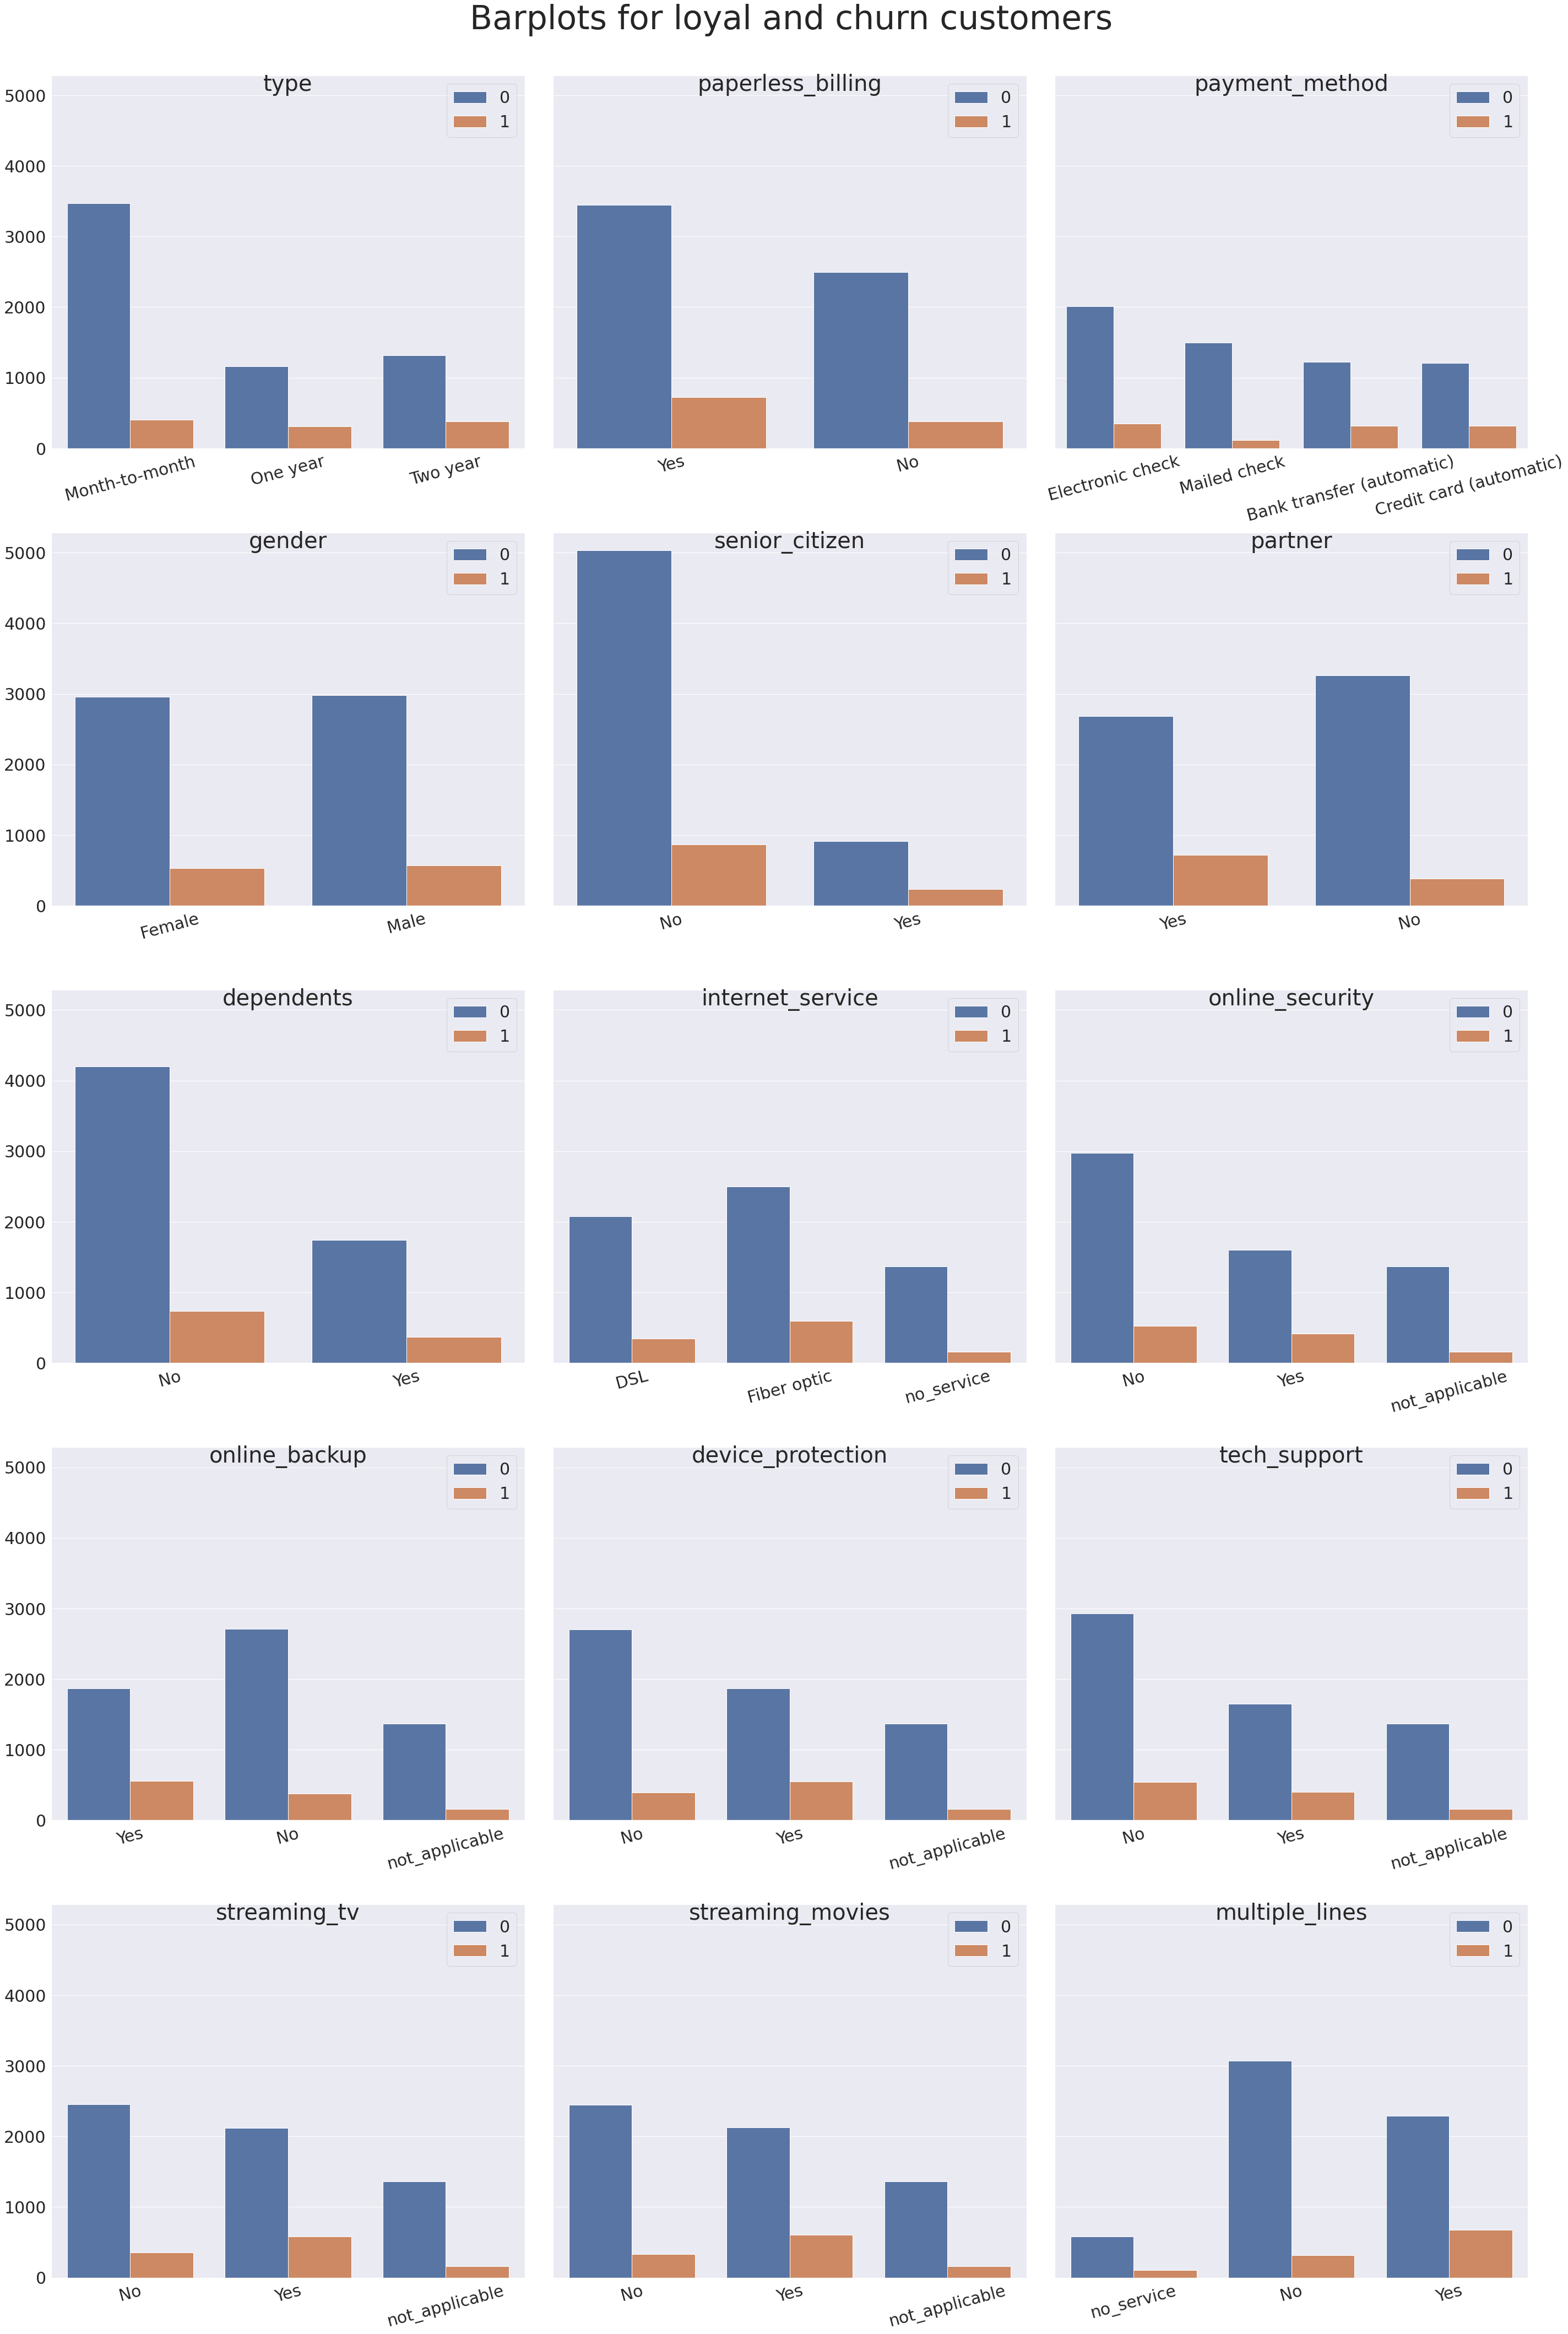

In [43]:
# не очень понял как элегантно сделать графики с таким большим количеством категориальных признаков
# и как лучше было постпуать: показать, что посмотрел на все признаки или оставить только интересные?
fig, axes = plt.subplots(5, 3, sharey=True, figsize=(40, 60))
fig.suptitle('Barplots for loyal and churn customers', fontsize=60)
for i, col in enumerate(categorical):
    ax = axes[int(i / 3), i % 3]
    sns.countplot(x=col, hue='churn', data=df, ax=ax).set_title(f'{col}', fontsize=40, y=0.95)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=30)
    ax.tick_params(axis='x', labelrotation=15)
    ax.legend(fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.95);

Наибольшие отличия в долях оттёкших клиентов наблюдаются в признаках:
- `internet_service`
- `online_backup`
- `device_protection`
- `streaming_movies`
- `multiple_lines`

Признак `monthly_charges` заметно дифференциирует клиентов.

## Обучение

In [44]:
RANDOM_STATE = 140823
RANDOM_SEED = RANDOM_STATE

В качестве срока жизни клиента оставим признак `customer_for_days`

In [45]:
X = df.drop('churn', axis=1).columns
y = ['churn']

In [46]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE, stratify=df[y])
print(f'Размер обучающей выборки {train.shape}, это составляет {len(train)/len(df):.2%} данных')
print(f'Размер тестовой выборки   {test.shape}, это составляет {len(test)/len(df):.2%} данных')

Размер обучающей выборки (5282, 19), это составляет 75.00% данных
Размер тестовой выборки   (1761, 19), это составляет 25.00% данных


In [47]:
train['churn'].value_counts(normalize=True)

test['churn'].value_counts(normalize=True)

churn
0    0.843839
1    0.156161
Name: proportion, dtype: float64

### Создание функций

In [48]:
kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [49]:
def go_random_grid(model, grid_params, n_iter, x_train, y_train):
    '''Hyperparameters tuning with GridSearchCV returns roc_auc CV score'''
    print("Performing grid search...")
    print("Hyperparameters to be evaluated:")
    pprint(grid_params)
    print()
    
    clf_rnd_gs = RandomizedSearchCV(model, 
                                    grid_params, 
                                    random_state=RANDOM_STATE,
                                    n_iter=n_iter,
                                    cv=5,
                                    verbose=4,
                                    n_jobs=-2,
                                    scoring='roc_auc')
    
    clf_rnd_gs.fit(x_train,y_train)
        
    name = 'Catboost' if 'catboost' in str(model).lower() else str(model).split(sep='(')[0].rstrip('Classifier')
    
    print('Best parameters:')
    for elem in clf_rnd_gs.best_params_:
        print(f'{elem}: {clf_rnd_gs.best_params_.get(elem)}')
    
    return name, clf_rnd_gs.best_params_, clf_rnd_gs.best_estimator_, clf_rnd_gs


In [50]:
def plot_cm_rocauc(model_name, actual_classes, predicted_classes, predicted_proba, dataset='с использованием кросс валидации на обучающей', sorted_labels = ['Loyal', 'Churn']):
    '''Ploting ROC curve and confusion matrix using predictions based on CV'''
    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="gnuplot", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix');

    plt.show()
        
    probabilities_one = predicted_proba[:, 1]
    
    sns.set(rc={'figure.figsize':(12, 8.6)})
    
    fpr, tpr, thresholds = roc_curve(actual_classes, probabilities_one) 
    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели ' + model_name)

    plt.show()
    
    rocauc = roc_auc_score(actual_classes, probabilities_one)
    accuracy = accuracy_score(actual_classes, predicted_classes)
    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)
    
    print(f'Метрики модели {model_name} {dataset} выборке')
    print(f'ROC-AUC   {rocauc:.3f}')
    print(f'Accuracy  {accuracy:.3f}')
    print(f'Precision {precision:.3f}')
    print(f'Recall    {recall:.3f}')

    
    return rocauc, accuracy, precision, recall


In [51]:
def cross_val_predict(model, kfold, X, y, dataset='с использованием кросс валидации на обучающей'):
    '''Predicting classes using CV(KFold)'''
    global name
    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    
    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = (X.iloc[train_ndx],
                                            y.iloc[train_ndx],
                                            X.iloc[test_ndx], 
                                            y.iloc[test_ndx])

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)
            
    rocauc, accuracy, precision, recall = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)
    
    return actual_classes, predicted_classes, predicted_proba, rocauc, accuracy, precision, recall


In [52]:
def plot_cm_rocauc(model_name, actual_classes, predicted_classes, predicted_proba, dataset='с использованием кросс валидации на обучающей', sorted_labels = ['Loyal', 'Churn']):
    '''Ploting ROC curve and confusion matrix using predictions based on CV'''
    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="gnuplot", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix');

    plt.show()
        
    probabilities_one = predicted_proba[:, 1]
    
    sns.set(rc={'figure.figsize':(12, 8.6)})
    
    fpr, tpr, thresholds = roc_curve(actual_classes, probabilities_one) 
    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели ' + model_name)

    plt.show()
    
    rocauc = roc_auc_score(actual_classes, probabilities_one)
    accuracy = accuracy_score(actual_classes, predicted_classes)
    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)
    
    print(f'Метрики модели {model_name} {dataset} выборке')
    print(f'ROC-AUC   {rocauc:.3f}')
    print(f'Accuracy  {accuracy:.3f}')
    print(f'Precision {precision:.3f}')
    print(f'Recall    {recall:.3f}')

    
    return rocauc, accuracy, precision, recall


In [53]:
def get_results(best_params):
    '''Accumulating and printing ML results'''
    global results, rocauc, accuracy, precision, recall, name

    results.loc[name] = [rocauc, accuracy, precision, recall, best_params]
    display(results.iloc[:, :4])
    
    return


In [54]:
def get_best_thr(y_true, predicted_proba):
    '''Finding best threshold based on F1_score'''
    thrs = np.unique(predicted_proba[:,1])
    scores = []
    for thr in tqdm(thrs):
        y_pred = (predicted_proba[:,1] >= thr).astype(int)
        score = f1_score(y_true, y_pred)
        scores.append(score)
    result_thr = pd.DataFrame({'thr':thrs, 'f1_score':scores})
    
    return result_thr


In [55]:
results = pd.DataFrame({'ROC-AUC': [],
                        'Accuracy': [],
                        'Precision': [],
                        'Recall': [],
                        'Best parameters' : []
})

### Encoding

In [56]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first') #удаляем первый столбец чтобы не попасть в дамми-ловушку

train_ohe = (pd.DataFrame(
     encoder.fit_transform(train[categorical]).toarray(),
     columns=encoder.get_feature_names_out(),
     index=train.index)
     .join([train[y], train[numerical]], how='left')
) 

test_ohe = (pd.DataFrame(
    encoder.transform(test[categorical]).toarray(),
    columns=encoder.get_feature_names_out(),
    index=test.index)
    .join([test[y], test[numerical]], how='left')
)

In [57]:
X_ohe = list(train_ohe.columns)
X_ohe.remove('churn')

### Random Forest

In [58]:
%%time

model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

grid_params = {
    'n_estimators': [300],
    'max_depth': [10],
    'min_samples_leaf': [10],
    'criterion': ['entropy'],
    'max_features': [None]
}
n_iter = 150

name, best_params_rf, best_model_rf, grid_rf = go_random_grid(model,
                                                              grid_params,
                                                              n_iter,
                                                              train_ohe[X_ohe],
                                                              train_ohe[y])

Performing grid search...
Hyperparameters to be evaluated:
{'criterion': ['entropy'],
 'max_depth': [10],
 'max_features': [None],
 'min_samples_leaf': [10],
 'n_estimators': [300]}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=300;, score=0.847 total time=   4.1s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=300;, score=0.827 total time=   4.1s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=300;, score=0.843 total time=   4.3s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=300;, score=0.807 total time=   4.6s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=300;, score=0.816 total time=   4.4s
Best parameters:
n_estimators: 300
min_samples_leaf: 10
max_features: None
max

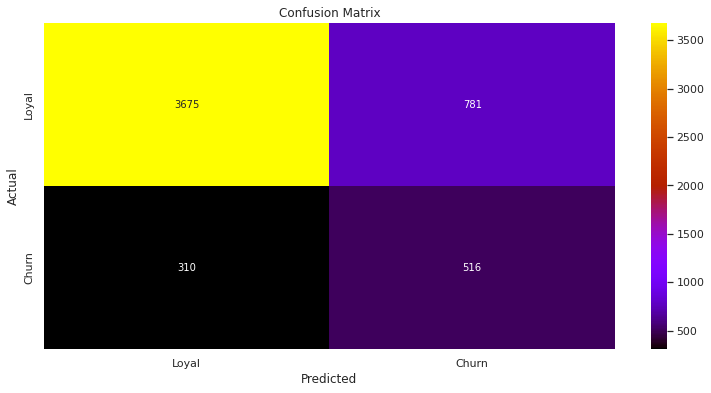

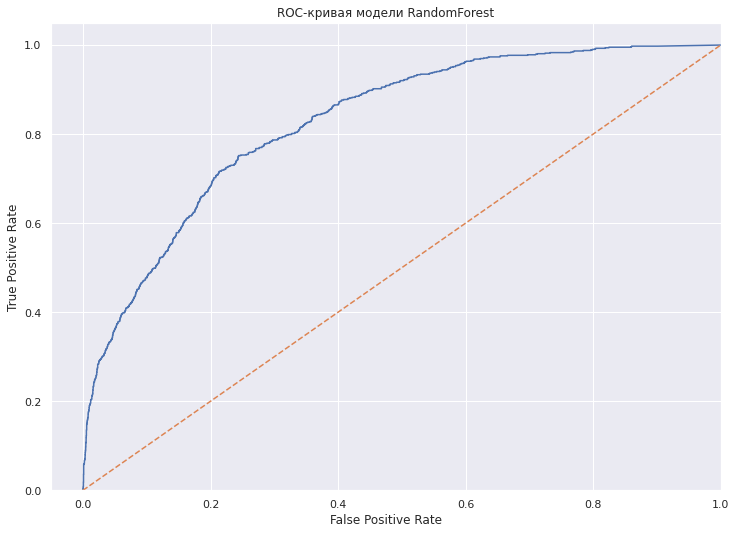

Метрики модели RandomForest с использованием кросс валидации на обучающей выборке
ROC-AUC   0.827
Accuracy  0.793
Precision 0.398
Recall    0.625


In [59]:
actual_classes_rf, predicted_classes_rf, predicted_proba_rf, rocauc, accuracy, precision, recall = cross_val_predict(best_model_rf, kfold, train_ohe[X_ohe], train_ohe[y])

Модель случайного леса показывает довольно низкий уровень precision(большое количество ложно положительных предсказаний).  
Использование такой модели будет приводить к потере прибыли из-за предложения скидок тем клиентам, которые не собирались уходить.

In [60]:
get_results(best_params_rf)

,ROC-AUC,Accuracy,Precision,Recall
RandomForest,0.827409,0.793449,0.397841,0.624697


### Catboost

In [61]:
cat_features = categorical

cb_params = {'cat_features': cat_features,
             'loss_function': 'Logloss',
             'eval_metric': 'AUC',
             'auto_class_weights': 'Balanced',
             'random_seed': RANDOM_SEED,
             'num_trees': 1000,
             'verbose': 0,
             'early_stopping_rounds': 100}

In [62]:
%%time

model = CatBoostClassifier(**cb_params)

grid_params = { 
    'learning_rate': [0.25],
    'depth': [4],
    'l2_leaf_reg': [2],
    'subsample': [1],
    'colsample_bylevel': [1],
}

n_iter = 100

name, best_params_cb, best_model_cb, grid_cb = go_random_grid(model,
                                                              grid_params,
                                                              n_iter,
                                                              train[X],
                                                              train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'colsample_bylevel': [1],
 'depth': [4],
 'l2_leaf_reg': [2],
 'learning_rate': [0.25],
 'subsample': [1]}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bylevel=1, depth=4, l2_leaf_reg=2, learning_rate=0.25, subsample=1;, score=0.925 total time=  11.6s
[CV 2/5] END colsample_bylevel=1, depth=4, l2_leaf_reg=2, learning_rate=0.25, subsample=1;, score=0.900 total time=  13.6s
[CV 3/5] END colsample_bylevel=1, depth=4, l2_leaf_reg=2, learning_rate=0.25, subsample=1;, score=0.912 total time=  12.2s
[CV 4/5] END colsample_bylevel=1, depth=4, l2_leaf_reg=2, learning_rate=0.25, subsample=1;, score=0.891 total time=  12.5s
[CV 5/5] END colsample_bylevel=1, depth=4, l2_leaf_reg=2, learning_rate=0.25, subsample=1;, score=0.917 total time=  13.4s
Best parameters:
subsample: 1
learning_rate: 0.25
l2_leaf_reg: 2
depth: 4
colsample_bylevel: 1
CPU times: user 1min 4s, sys: 1.31 s, total: 1min 6s
Wall time:

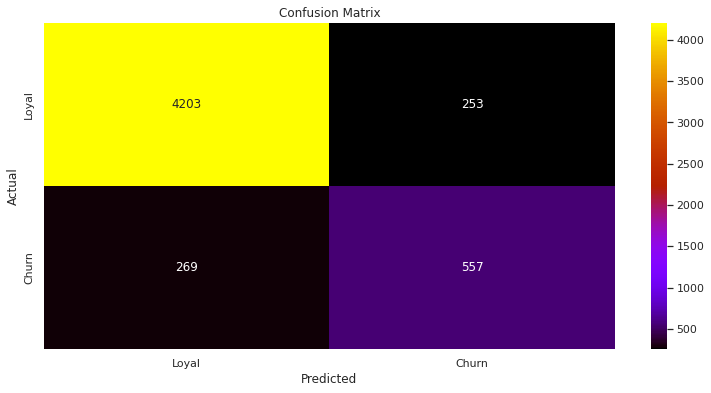

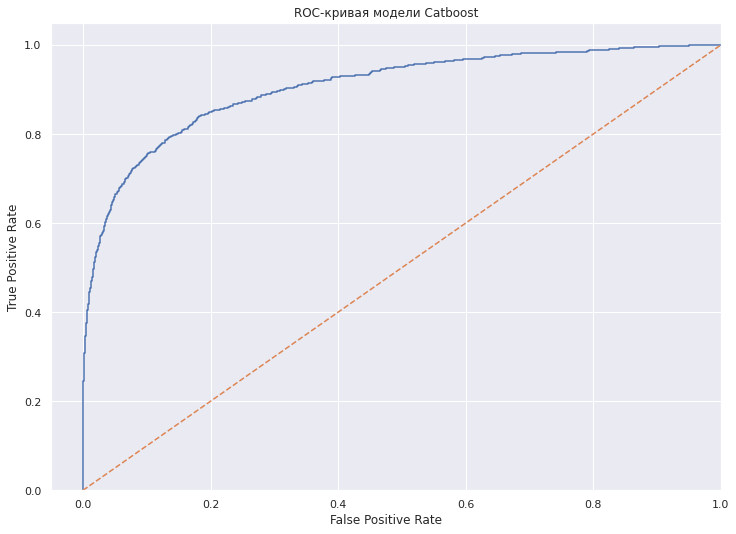

Метрики модели Catboost с использованием кросс валидации на обучающей выборке
ROC-AUC   0.906
Accuracy  0.901
Precision 0.688
Recall    0.674


In [63]:
actual_classes_cb, predicted_classes_cb, predicted_proba_cb, rocauc, accuracy, precision, recall = cross_val_predict(best_model_cb, kfold, train[X], train[y])

Модель Catboost показывает практически идентичный результат среди верно положительных предскзаний, значительно сократив количество ложно положительных - метрика точности значительно выше. Уровень полноты же практически не уменьшился. Accuracy = 90% против 79% у модели случайного леса.

In [ ]:
get_results(best_params_cb)

### Catboost Optuna

In [69]:
import optuna
from sklearn.model_selection import cross_val_score

In [70]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    depth = trial.suggest_categorical('depth', [4, 5])
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.01, 1)
    
    model = CatBoostClassifier(**cb_params,
                               learning_rate=learning_rate,
                               depth=depth,
                               l2_leaf_reg=l2_leaf_reg,
                               subsample=subsample,
                               colsample_bylevel = colsample_bylevel
                              )
    score = cross_val_score(model, train[X], train[y], cv=5, scoring='roc_auc').mean()
    return score

In [71]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-09-03 13:39:24,014] A new study created in memory with name: no-name-a275478f-b564-441c-8f6f-e1b704b83a3d
[I 2023-09-03 13:39:49,875] Trial 0 finished with value: 0.8400112062375082 and parameters: {'learning_rate': 0.4418324668825925, 'depth': 4, 'l2_leaf_reg': 7.306003348077713, 'subsample': 0.1653609916886557, 'colsample_bylevel': 0.3022971731966985}. Best is trial 0 with value: 0.8400112062375082.
[I 2023-09-03 13:40:23,170] Trial 1 finished with value: 0.8461510416721506 and parameters: {'learning_rate': 0.75984061911355, 'depth': 5, 'l2_leaf_reg': 3.983598439339644, 'subsample': 0.6735896121509958, 'colsample_bylevel': 0.3355430903081619}. Best is trial 1 with value: 0.8461510416721506.
[I 2023-09-03 13:41:07,711] Trial 2 finished with value: 0.888977676233573 and parameters: {'learning_rate': 0.2788289771875231, 'depth': 5, 'l2_leaf_reg': 7.903835401745194, 'subsample': 0.46288102864164504, 'colsample_bylevel': 0.7378083444790897}. Best is trial 2 with value: 0.888977676

In [72]:
best_params_opt_cb = study.best_params
best_score_opt_cb = study.best_value

In [73]:
print(best_params_opt_cb)
print(best_score_opt_cb)

{'learning_rate': 0.20957959090572104, 'depth': 4, 'l2_leaf_reg': 1.0283687945220632, 'subsample': 0.9184519680391755, 'colsample_bylevel': 0.9916180107017771}
0.9096951519766192


In [75]:
model = CatBoostClassifier(**cb_params, **best_params_opt_cb)

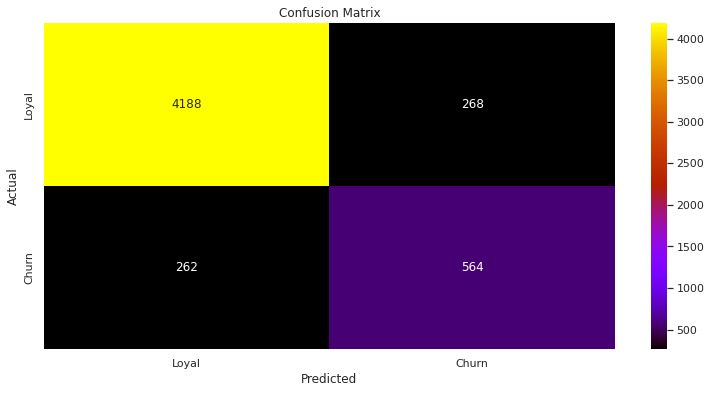

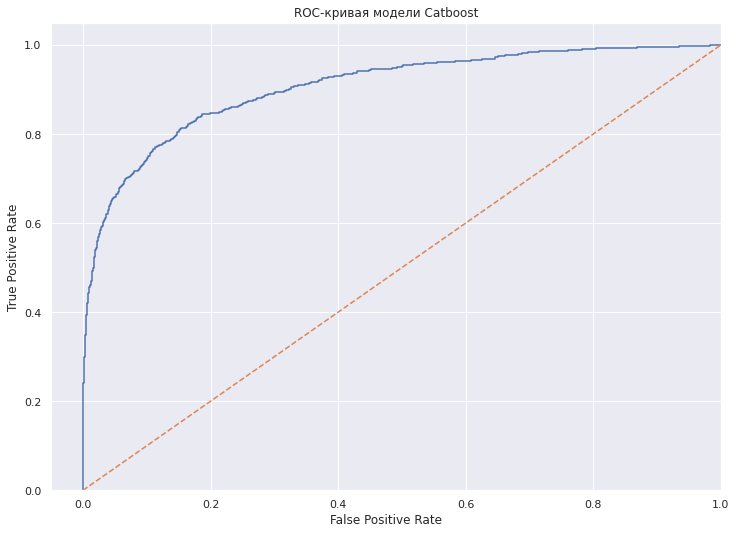

Метрики модели Catboost с использованием кросс валидации на обучающей выборке
ROC-AUC   0.906
Accuracy  0.900
Precision 0.678
Recall    0.683


In [76]:
actual_classes_cb, predicted_classes_cb, predicted_proba_cb, rocauc, accuracy, precision, recall = cross_val_predict(model, kfold, train[X], train[y])

In [ ]:
optuna_best_params_cb = {'learning_rate': 0.5437652621742946,
                         'depth': 4,
                         'l2_leaf_reg': 7.2159202993154725,
                         'subsample': 0.7555948785431398,
                         'colsample_bylevel': 0.9984238597851037}

### LGBM

In [ ]:
train_lgbm = train.copy()
test_lgbm = test.copy()
train_lgbm[categorical] = train_lgbm[categorical].astype('category')
test_lgbm[categorical] = test_lgbm[categorical].astype('category')

In [ ]:
lgbm_params = {'objective':'binary', 
               'class_weight':'balanced', 
               'metric':'auc', 
               'random_state':RANDOM_STATE, 
               'silent':True,
               'verbose':-1}

In [ ]:
%%time

model = LGBMClassifier(**lgbm_params)

grid_params = { 
    'learning_rate': [0.2],
    'n_estimators': [350],
    'max_depth': [4]               
}

n_iter = 50

name, best_params_lgbm, best_model_lgbm, grid_lgbm = go_random_grid(model,
                                                                    grid_params,
                                                                    n_iter,
                                                                    train_lgbm[X],
                                                                    train_lgbm[y])

In [ ]:
actual_classes_lgbm, predicted_classes_lgbm, predicted_proba_lgbm, rocauc, accuracy, precision, recall = cross_val_predict(best_model_lgbm, kfold, train_lgbm[X], train_lgbm[y])

In [ ]:
get_results(best_params_lgbm)

Модель LGBM показывает похожие с Catboost результаты, но уступает в precision.

### Оценка скорости обучения и предсказания моделей

In [ ]:
results_timings = pd.DataFrame({'Train time':[], 'Predict time':[]})

In [ ]:
results_timings.loc['RandomForest'] = [grid_rf.cv_results_['mean_fit_time'][0],
                                       grid_rf.cv_results_['mean_score_time'][0]]

results_timings.loc['Catboost'] = [grid_cb.cv_results_['mean_fit_time'][0],
                                   grid_cb.cv_results_['mean_score_time'][0]]

results_timings.loc['LGBM'] = [grid_lgbm.cv_results_['mean_fit_time'][0],
                               grid_lgbm.cv_results_['mean_score_time'][0]]


In [ ]:
results_timings

Значительной разницы в скорости предсказания не наблюдается, разница в скорости обучения модели в рамках решаемой задачи не является критичной.

In [ ]:
results.iloc[:,:4]

Учитывая результаты, выберем Catboost как лучшую модель.

### Проверка важности признаков лучшей модели

In [77]:
model = best_model_cb
model.fit(train[X], train[y]);

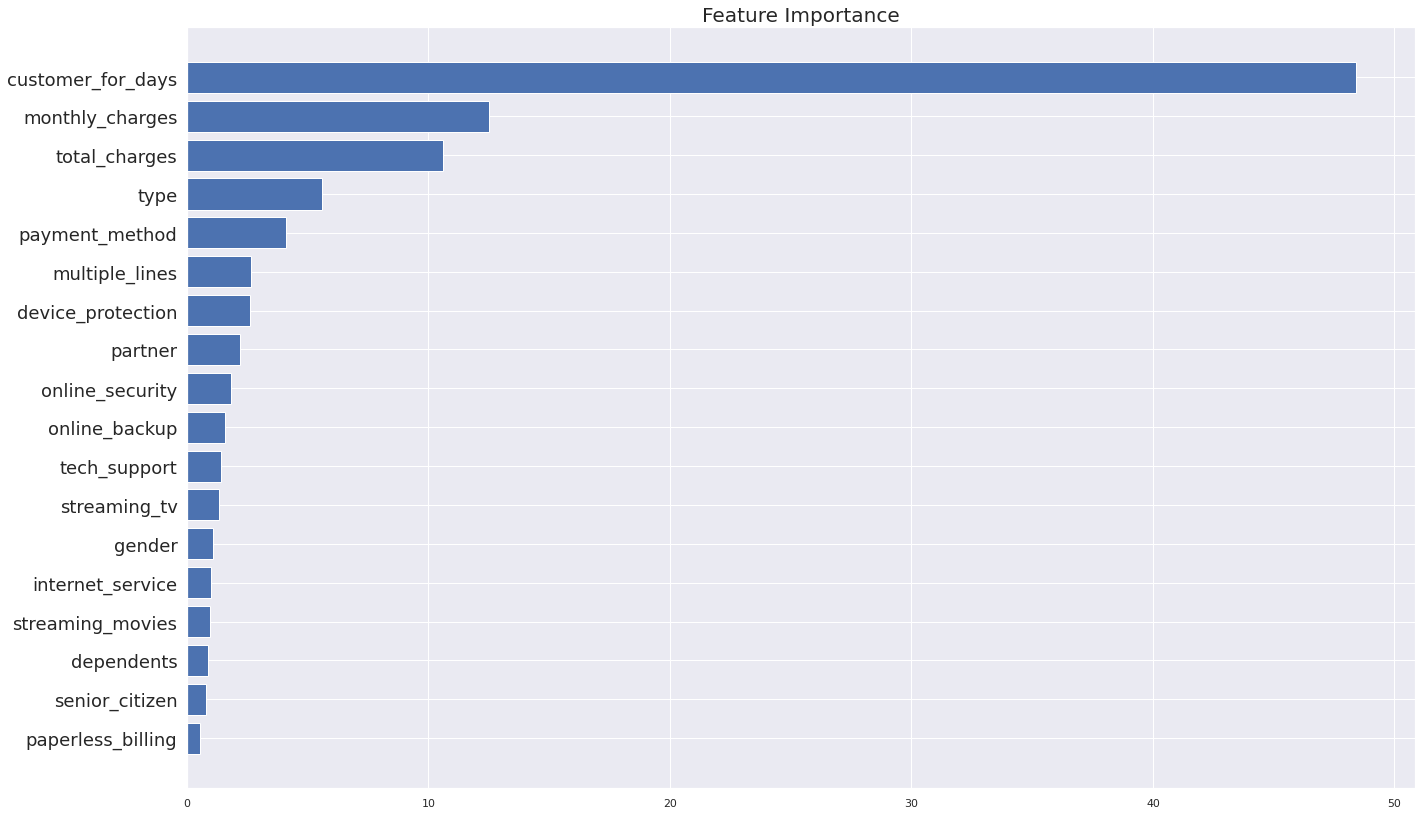

In [78]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(22, 14))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test[X].columns)[sorted_idx], fontsize=18)
plt.title('Feature Importance', fontsize=20);

In [79]:
# Попробуем оставить только наиболее важные признаки
# также удалим один из двух созависимых признаков размера оплаты (total_charges) как менее важный
X_new = ['customer_for_days', 'device_protection', 
        'monthly_charges', 'multiple_lines','partner',
        'payment_method', 'type']

In [80]:
cat_features = ['type',
                'payment_method',
                'partner',
                'device_protection',
                'multiple_lines']

In [81]:
cb_params['cat_features'] = cat_features

In [104]:
model = CatBoostClassifier(**cb_params, **best_params_cb)

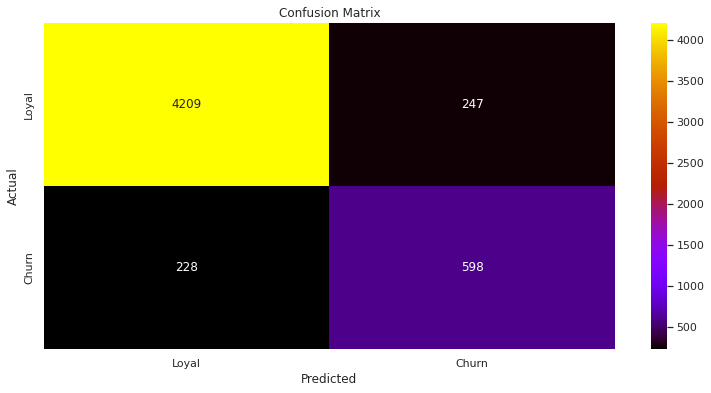

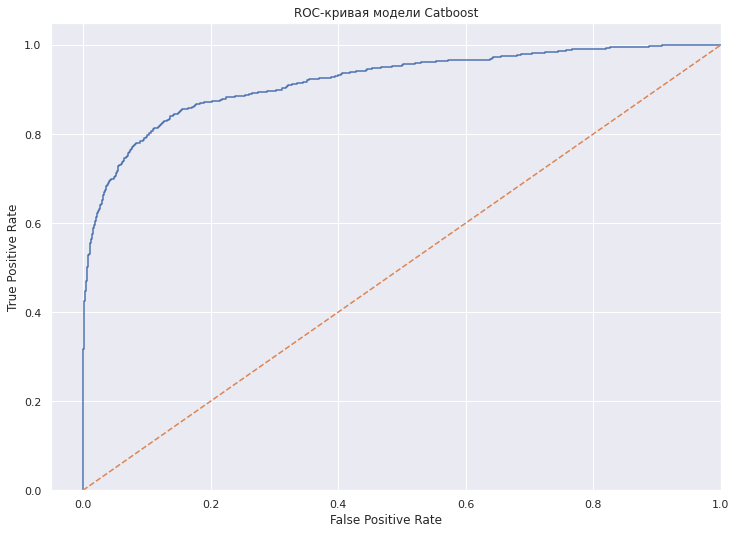

Метрики модели Catboost с использованием кросс валидации на обучающей выборке
ROC-AUC   0.919
Accuracy  0.910
Precision 0.708
Recall    0.724


In [105]:
name = 'Catboost'
actual_classes_cb_lf, predicted_classes_cb_lf, predicted_proba_cb_lf, rocauc, accuracy, precision, recall = cross_val_predict(model, kfold, train[X_new], train[y], 'с использованием ограниченного количества признаков на кросс-валидации на обучающей')

In [84]:
results.iloc[1:2,:4]

,ROC-AUC,Accuracy,Precision,Recall


Модель, обученная на ограниченном наборе признаков, показывает результат лучше, будем проверять её на тестовой выборке.

### Вывод

Ключевые моменты на этапе обучения:
- разделены данные на обучающую и тестовую выборки в пропорции 3:1 с использованием стратификации;
- категориальные переменные закодированы для модели RandomForest с использованием One Hot Encoding;
- выполнена подбор гиперпараметров для 3-ёх моделей (RandomForest, Catboost, LGBM) с использованием кросс-валидации на обучающей выборке (5 фолдов)
- проведено сравнение требуемого времени для обучения моделей и осуществления предсказаний, время обучения не играет критической роли в решаемой задаче, по времени предсказания на имеющемся объёме данных все модели показывают отличный результат (< 0.2 сек.) 
- наилучшие метрики продемонстрировала модель CatBoost (ROC-AUC = 0.905, Accuracy = 0.901)
- была осуществлена проверка важности признаков для лучшей модели, на основании этого мы обучили модель заново на ограниченном объёме признаков, результат улучшился (ROC-AUC 0.919, Accuracy 0.910).

## Проверка лучшей модели на тестовой выборке

In [106]:
# Подберём лучший порог, базируясь на CV предсказаниях обучающей выборки и используем его на тестовой выборке
result_thr = get_best_thr(actual_classes_cb_lf, predicted_proba_cb_lf)

100%|██████████| 5208/5208 [00:14<00:00, 363.40it/s]


In [107]:
best_thr_f1 = result_thr.sort_values('f1_score', ascending=False).iloc[0,0]
display(result_thr.sort_values('f1_score', ascending=False).head(1))

,thr,f1_score
4483,0.611736,0.726804


In [108]:
model = CatBoostClassifier(**cb_params, **best_params_cb)

In [109]:
model.fit(train[X_new], train[y])

In [110]:
predicted_proba_t = model.predict_proba(test[X_new])

In [111]:
predicted_classes_t = (predicted_proba_t[:,1] >= best_thr_f1).astype(int)

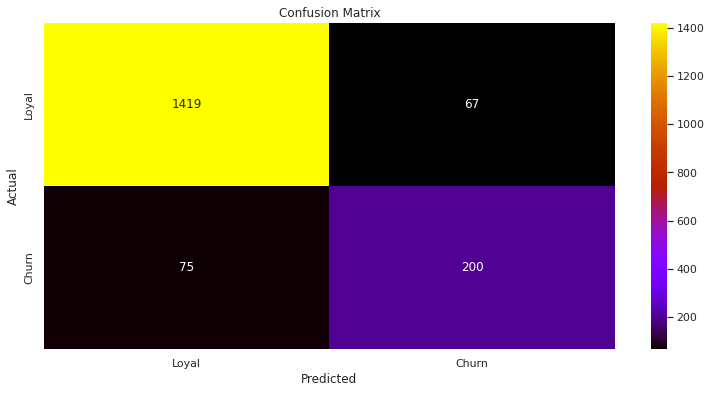

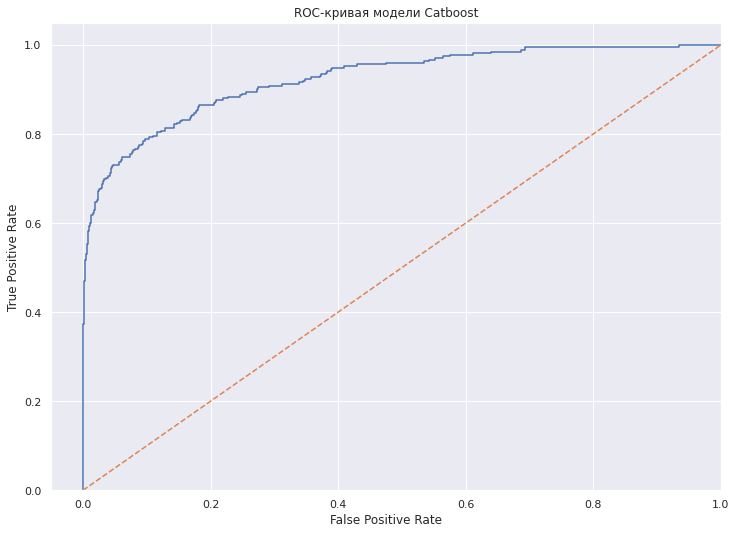

Метрики модели Catboost с подбором лучшего порога (по CV предсказаниям) на тестовой выборке
ROC-AUC   0.924
Accuracy  0.919
Precision 0.749
Recall    0.727


In [112]:
rocauc, accuracy, precision, recall = plot_cm_rocauc('Catboost', test[y], predicted_classes_t, predicted_proba_t, 'с подбором лучшего порога (по CV предсказаниям) на тестовой')

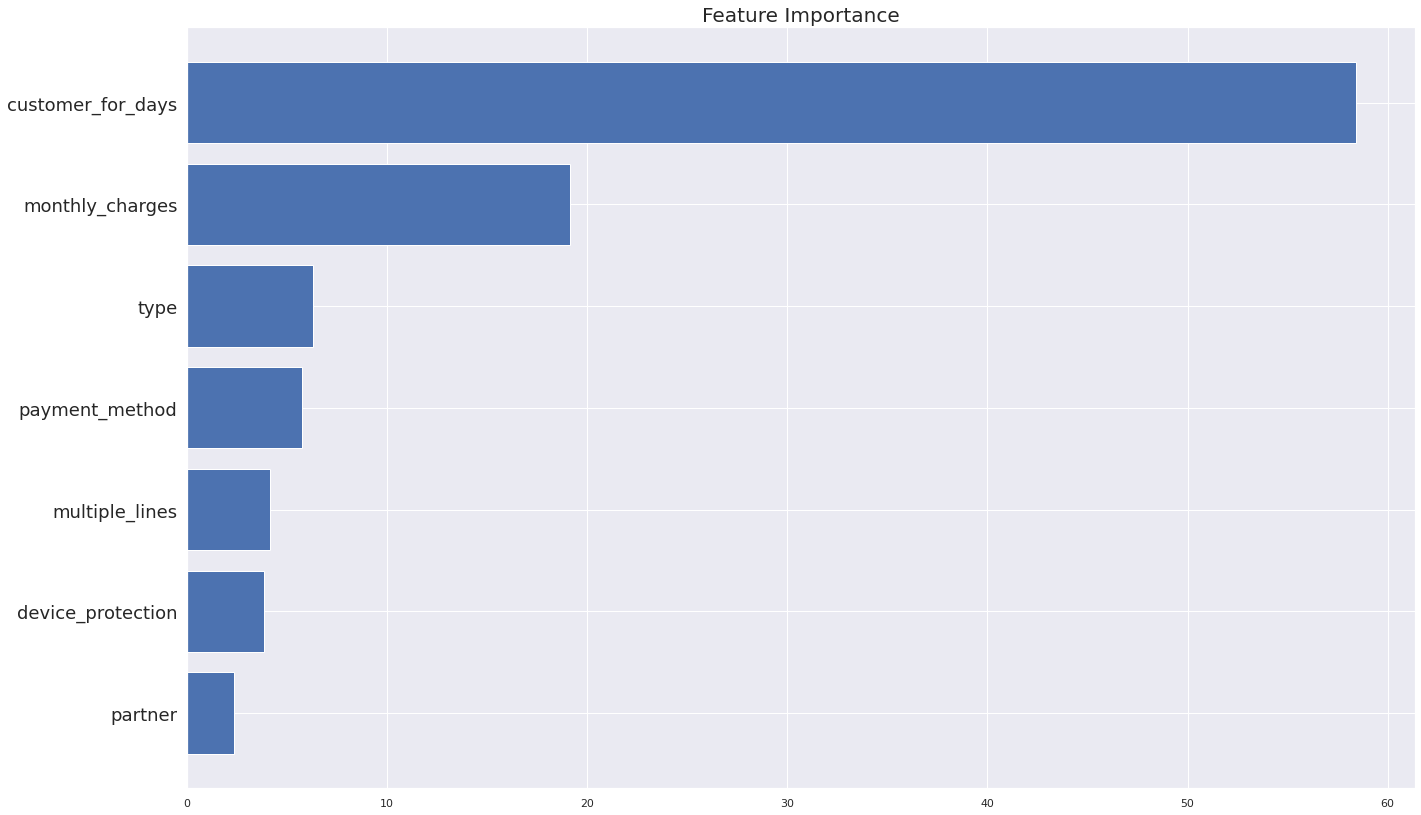

In [113]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(22, 14))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test[X_new].columns)[sorted_idx], fontsize=18)
plt.title('Feature Importance', fontsize=20);

In [114]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X_new])

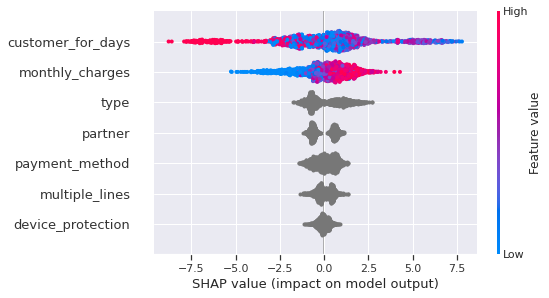

In [115]:
shap.summary_plot(shap_values, test[X_new])

In [116]:
features = model.get_feature_importance(prettified=True)['Feature Id'].values

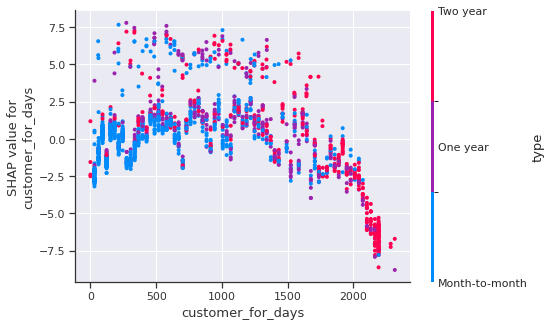

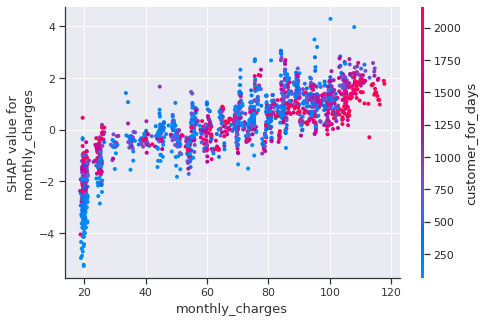

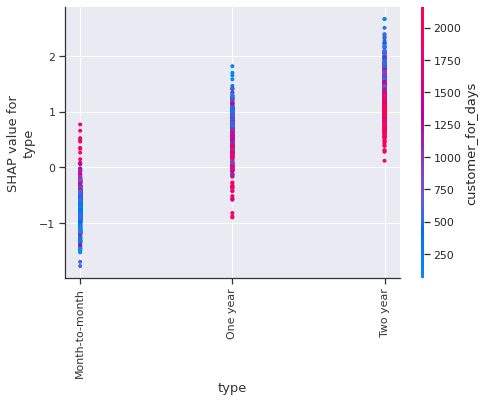

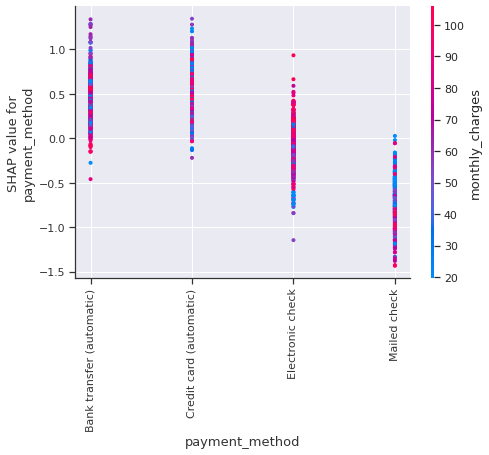

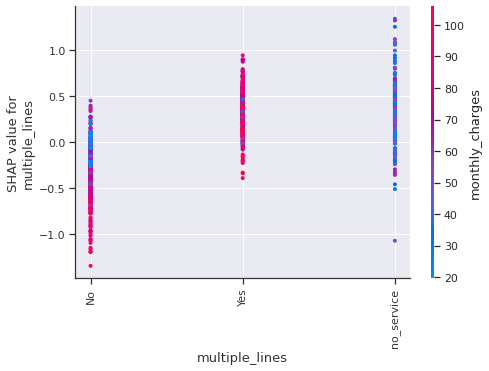

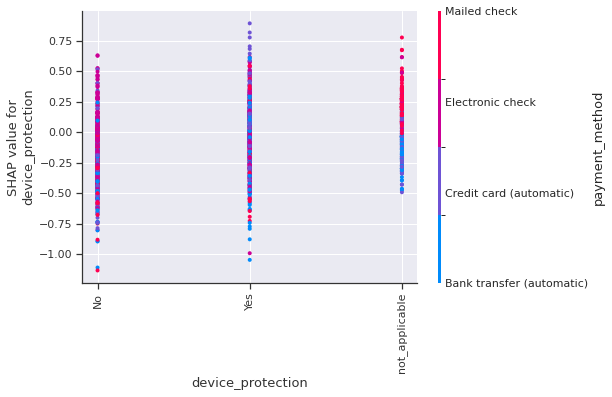

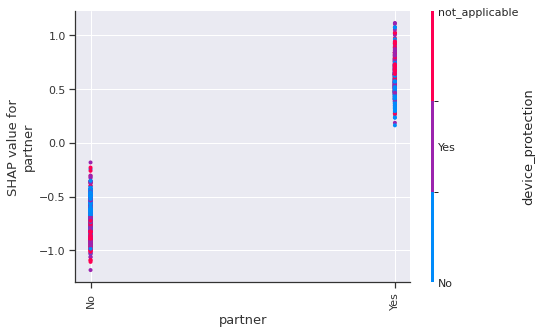

In [117]:
for f in features:
    shap.dependence_plot(f, shap_values, test[X_new])

- Уровень оттока выше среди клиентов с ежемесячным типом оплаты, рекомендуется переводить клиентов на годовые тарифные планы;
- Размер ежемесячной оплаты негативно влияет на отток клиентов, уровень оттока растёт быстрее при оплате ~ более 60 у.е.;
- Среди способов оплаты негативный эффект сильнее у клиентов, использующих `Bank transfer(auto)` и `Credit Card(auto)`, `Mailed_check` наоборот влияет положительно на срок жизни;

### Вывод

С использованием подбора лучшего порога на базе CV предсказаний обучающей выборки, модель Catboost демонстрирует следующие результаты на тетсовых данных:
- ROC-AUC   0.924
- Accuracy  0.919
- Precision 0.749
- Recall    0.727

## Отчёт по проекту

Верхнеуровневый план работы, созданный на стартовом этапе.
- Загрузка и предобработка данных
- Исследовательский анализ данных
- Машинное обучение
- Проверка лучшей модели на тестовой выборке
- Исследование важности признаков лучшей модели

Все пункты плана были реализованы.


Наибольшую трудность вызвала моя невнимательность, а именно - попытка получить требуемый уровень ROC-AUC на тестовой выборке в 0.85, упорно передавая в roc_auc_score(y_true, **y_pred**). В момент твоего вещания на эту тему, я отметил для себя, что понимаю о чём идёт речь и меня это не коснётся, но видимо необходимо было набить эту шишку "руками".


Ключевыми шагами были: 
- перебор гиперпараметров
- оценка важности признаков (это помогло улучшить результат ~ на 2 п.п.)
- подбор порогового значения


Итоговая модель - Catboost со следующим набором гиперпараметров:  

'subsample': 1,  
'learning_rate': 0.25,  
'l2_leaf_reg': 2,  
'depth': 4,  
'colsample_bylevel': 1,  
'loss_function': 'Logloss',  
'eval_metric': 'AUC',  
'auto_class_weights': 'Balanced',  
'random_state': 140823.


Был использован следующий список признаков:  
`customer_for_days` - срок жизни клиента в днях до момента разрыва взаимоотношений/до сегодняшнего дня (создан)  
`monthly_charges` - размер оплаты в месяц  
`type` - периодичность оплаты  
`payment_method` - способ оплаты  
`multiple_lines` - подключение телефона к нескольким линиям одновременно (пропуски заполнены 'no_service')  
`device_protection` - наличие антивируса (пропуски заполнены 'not_applicable')  
`partner` - наличие супруги(а) (пропуски заполнены 'not_applicable')  


Метрики, полученные на тестовой выборке:  
ROC-AUC 0.924 | Accuracy  0.919 | Precision 0.749 | Recall    0.727  
